### Lab-08_1: Perceptron

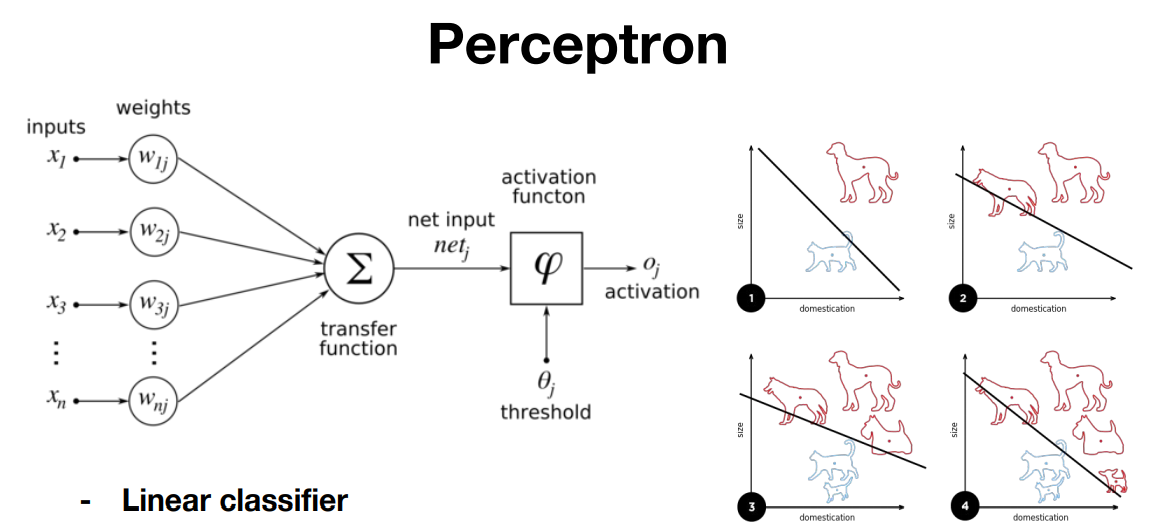

In [ ]:
# XOR에 대한 Perceptron을 구현
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

In [ ]:
# nn layers -> Perceptron의 경우 1개의 Layer
linear = torch.nn.Linear(2, 1, bias=True) # Fully-connected Layer
sigmoid = torch.nn.Sigmoid()

# model
model = torch.nn.Sequential(linear, sigmoid).to(device)

# define cost/loss & optimizer
criterion = torch.nn.BCELoss().to(device) # 우리가 '이진분류'를 수행하고 있기 때문
optimizer = torch.optim.SGD(model.parameters(), lr=1)

for step in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)

    # cost/loss function
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    if step % 100 == 0: # 200번째 이후부터 학습이 제대로 이루어지지 않음을 알 수 있음
        print(step, cost.item())

In [ ]:
# Accuracy computation
# True if hypothesis>0.5 else False
with torch.no_grad():
    hypothesis = model(X) # 모든 결과가 0.5가 됨...
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('\nHypothesis: ', hypothesis.detach().cpu().numpy(), 
          '\nCorrect: ', predicted.detach().cpu().numpy(), 
          '\nAccuracy: ', accuracy.item())


Hypothesis:  [[0.5]
 [0.5]
 [0.5]
 [0.5]] 
Correct:  [[0.]
 [0.]
 [0.]
 [0.]] 
Accuracy:  0.5


##### XOR_nn_wide_deep

In [ ]:
# 각 층을 더 넓게(뉴런의 수 증가)하고 층의 개수도 늘려보자! 
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# data
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

# nn layers
linear1 = torch.nn.Linear(2, 10, bias=True)
linear2 = torch.nn.Linear(10, 10, bias=True)
linear3 = torch.nn.Linear(10, 10, bias=True)
linear4 = torch.nn.Linear(10, 1, bias=True)
sigmoid = torch.nn.Sigmoid()

# model
model = torch.nn.Sequential(linear1, sigmoid, linear2, sigmoid, linear3, sigmoid, linear4, sigmoid).to(device)

# define cost/loss & optimizer
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)  # modified learning rate from 0.1 to 1

for step in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)

    # cost/loss function
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    if step % 100 == 0:
        print(step, cost.item())

In [ ]:
# Accuracy computation
# True if hypothesis>0.5 else False
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('\nHypothesis: ', hypothesis.detach().cpu().numpy(), 
          '\nCorrect: ', predicted.detach().cpu().numpy(), 
          '\nAccuracy: ', accuracy.item())

### Lab-08_2: Multi Layer Perceptron
- Perceptron과 달리, MLP는 결정경계가 2개가 되는 것처럼 생각할
 수 있으므로 XOR 문제를 해결할 수 있음
  - 하지만, 초기에 이 모델을 학습시키는 방법은 아무도 몰랐음

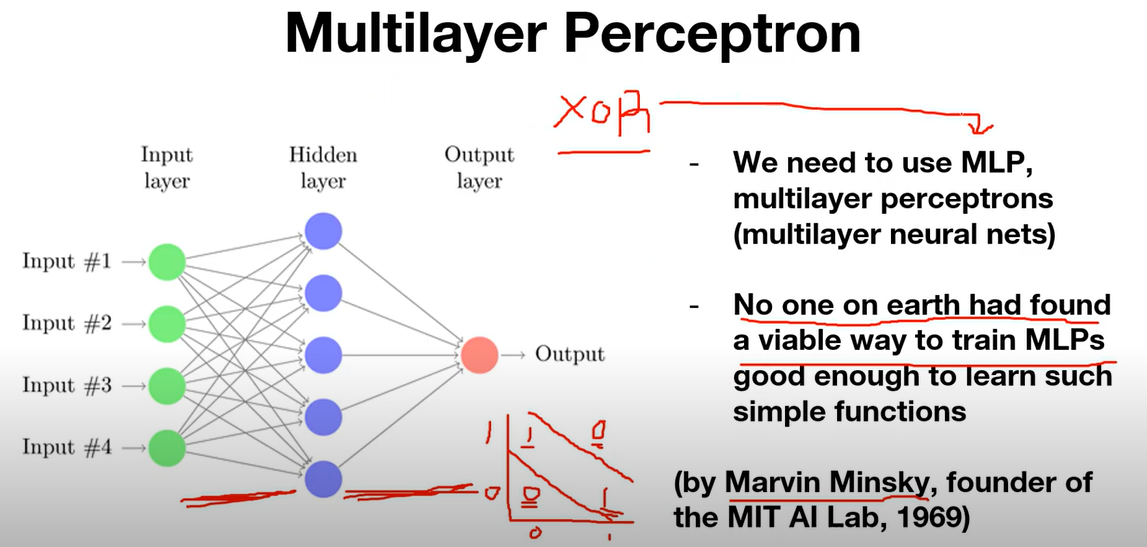

- Backpropagation을 이용해 MLP를 학습시킬 수 있게 되었음

In [ ]:
## Backpropagation

import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# data
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

learning_rate = 0.5

# nn layers
w1 = torch.nn.Parameter(torch.Tensor(2,2)).to(device)
b1 = torch.nn.Parameter(torch.Tensor(2)).to(device)
w2 = torch.nn.Parameter(torch.Tensor(2,1)).to(device)
b2 = torch.nn.Parameter(torch.Tensor(1)).to(device)

# 아래의 코드로 초기화하지 않으면 cost에 nan 값 들어가는 문제 발생
torch.nn.init.normal_(w1)
torch.nn.init.normal_(b1)
torch.nn.init.normal_(w2)
torch.nn.init.normal_(b2)
# -> nn.Linear

def sigmoid(x):
  # sigmoid function
  return 1.0 / (1.0 + torch.exp(-x))

def sigmoid_prime(x):
  return sigmoid(x) * (1 - sigmoid(x))

for step in range(10001):
  ## forward
  l1 = torch.add(torch.matmul(X, w1), b1)
  a1 = sigmoid(l1)
  l2 = torch.add(torch.matmul(a1, w2), b2)
  Y_pred = sigmoid(l2)
  cost = -torch.mean(Y * torch.log(Y_pred) + (1 - Y) * torch.log(1 - Y_pred)) # BCE Loss 사용하는 것!

  ## Back prop (chain rule) -> PyTorch 에서는 cost.backward() 함수로 해결!!
  # Loss derivative
  d_Y_pred = (Y_pred - Y) / (Y_pred * (1.0 - Y_pred) + 1e-7) # BCE를 미분, '1e-7'은 0이 되는 것을 예방 
  
  # Layer 2
  d_l2 = d_Y_pred * sigmoid_prime(l2)
  d_b2 = d_l2
  d_w2 = torch.matmul(torch.transpose(a1, 0, 1), d_b2) # .transpose(?, 0, 1) -> 0축과 1축을 바꿔라
  
  # Layer 1
  d_a1 = torch.matmul(d_b2, torch.transpose(w2, 0, 1))
  d_l1 = d_a1 * sigmoid_prime(l1)
  d_b1 = d_l1
  d_w1 = torch.matmul(torch.transpose(X, 0, 1), d_b1)

  ## Weight update -> PyTorch 에서는 optimizer.step() 함수로 해결!!
  w1 = w1 - learning_rate * d_w1
  b1 = b1 - learning_rate * torch.mean(d_b1, 0)
  w2 = w2 - learning_rate * d_w2
  b2 = b2 - learning_rate * torch.mean(d_b2, 0)

  if step % 100 == 0:
    print(step, cost.item())


##### Backpropagation with MNIST 

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# parameters
learning_rate = 0.5
batch_size = 10

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [ ]:
w1 = torch.nn.Parameter(torch.Tensor(784, 30)).to(device)
b1 = torch.nn.Parameter(torch.Tensor(30)).to(device)
w2 = torch.nn.Parameter(torch.Tensor(30, 10)).to(device)
b2 = torch.nn.Parameter(torch.Tensor(10)).to(device)

torch.nn.init.normal_(w1)
torch.nn.init.normal_(b1)
torch.nn.init.normal_(w2)
torch.nn.init.normal_(b2)

tensor([ 0.1009, -0.2272, -0.1022, -0.9369,  0.6552, -0.8914,  0.1989,  0.7264,
         0.3932, -0.5963], device='cuda:0', grad_fn=<CopyBackwards>)

In [ ]:
def sigmoid(x):
    #  sigmoid function
    return 1.0 / (1.0 + torch.exp(-x))
    # return torch.div(torch.tensor(1), torch.add(torch.tensor(1.0), torch.exp(-x)))

def sigmoid_prime(x):
    # derivative of the sigmoid function
    return sigmoid(x) * (1 - sigmoid(x))

In [ ]:
X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)[:1000]
Y_test = mnist_test.test_labels.to(device)[:1000]
i = 0
while not i == 10000:
    for X, Y in data_loader:
        i += 1

        # forward
        X = X.view(-1, 28 * 28).to(device)
        Y = torch.zeros((batch_size, 10)).scatter_(1, Y.unsqueeze(1), 1).to(device)    # one-hot
        l1 = torch.add(torch.matmul(X, w1), b1)
        a1 = sigmoid(l1)
        l2 = torch.add(torch.matmul(a1, w2), b2)
        y_pred = sigmoid(l2)

        diff = y_pred - Y

        # Back prop (chain rule)
        d_l2 = diff * sigmoid_prime(l2)
        d_b2 = d_l2
        d_w2 = torch.matmul(torch.transpose(a1, 0, 1), d_l2)

        d_a1 = torch.matmul(d_l2, torch.transpose(w2, 0, 1))
        d_l1 = d_a1 * sigmoid_prime(l1)
        d_b1 = d_l1
        d_w1 = torch.matmul(torch.transpose(X, 0, 1), d_l1)

        w1 = w1 - learning_rate * d_w1
        b1 = b1 - learning_rate * torch.mean(d_b1, 0)
        w2 = w2 - learning_rate * d_w2
        b2 = b2 - learning_rate * torch.mean(d_b2, 0)

        if i % 1000 == 0:
            l1 = torch.add(torch.matmul(X_test, w1), b1)
            a1 = sigmoid(l1)
            l2 = torch.add(torch.matmul(a1, w2), b2)
            y_pred = sigmoid(l2)
            acct_mat = torch.argmax(y_pred, 1) == Y_test
            acct_res = acct_mat.sum()
            print(acct_res.item())

        if i == 10000:
            break